In [1]:
!wget https://vision.middlebury.edu/stereo/data/scenes2005/ThirdSize/zip-2views/ALL-2views.zip
!unzip "ALL-2views.zip" -d "data/"

--2025-02-05 18:08:02--  https://vision.middlebury.edu/stereo/data/scenes2005/ThirdSize/zip-2views/ALL-2views.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954873 (4.7M) [application/zip]
Saving to: ‘ALL-2views.zip’

ALL-2views.zip      100%[===================>]   4.72M  1.59MB/s    in 3.0s    

2025-02-05 18:08:10 (1.59 MB/s) - ‘ALL-2views.zip’ saved [4954873/4954873]

Archive:  ALL-2views.zip
 extracting: data/Art/disp1.png      
 extracting: data/Art/disp5.png      
  inflating: data/Art/view1.png      
  inflating: data/Art/view5.png      
 extracting: data/Books/disp1.png    
 extracting: data/Books/disp5.png    
  inflating: data/Books/view1.png    
  inflating: data/Books/view5.png    
  inflating: data/Computer/view1.png  
  inflating: data/Computer/view5.png  
  inflating: data/Dolls/disp1.png    
 

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocess import Pool, cpu_count

/Users/irsh/Documents/workdir/ec69210/exp4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
class Similarity:
    @staticmethod
    def SSD(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        return -np.sum((patch1 - patch2) ** 2  / (patch1.shape[0] * patch1.shape[1]))

    @staticmethod
    def ZNCC(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        patch1, patch2 = patch1.astype(float), patch2.astype(float)
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]

        zncc_sum = 0

        for c in range(patch1.shape[2]):
            p1, p2 = patch1[:, :, c] - patch1[:, :, c].mean(), patch2[:, :, c] - patch2[:, :, c].mean()
            std1, std2 = np.std(p1), np.std(p2)
            if std1 == 0 or std2 == 0:
                continue
            zncc_sum += (p1 * p2).sum() / (std1 * std2)

        return zncc_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

    @staticmethod
    def CENSUS(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]
        diffs_sum = 0
        for c in range(patch1.shape[2]):
            n = patch1.shape[0]
            pt1, pt2 = patch1[n//2, n//2, c], patch2[n//2, n//2, c]
            b1, b2 = "".join(map(str, (patch1[:, :, c] > pt1).flatten().astype(int))), \
                     "".join(map(str, (patch2[:, :, c] > pt2).flatten().astype(int)))
            diffs_sum += sum(1 for x1, x2 in zip(b1, b2) if x1 != x2)

        return -diffs_sum / (patch1.shape[0] * patch1.shape[1])

    @staticmethod
    def RANK(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]
        rank_corr_sum = 0
        for c in range(patch1.shape[2]):
            p1, p2 = patch1[:, :, c].flatten(), patch2[:, :, c].flatten()
            rank1, rank2 = np.argsort(np.argsort(p1)), np.argsort(np.argsort(p2))
            rank1, rank2 = rank1.reshape(patch1.shape[:2]).astype(float), rank2.reshape(patch1.shape[:2]).astype(float)
            rank1 -= rank1.mean()
            rank2 -= rank2.mean()
            std1, std2 = np.std(rank1), np.std(rank2)
            if std1 == 0 or std2 == 0:
                continue
            rank_corr_sum += (rank1 * rank2).sum() / (std1 * std2)

        return rank_corr_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]


In [3]:
class StereoView:
    def __init__(self, folder, gray=False, max_disparity=.33):
        self.folder = folder
        self.imgl = self._load_image(os.path.join(folder, "view1.png"), gray)
        self.imgr = self._load_image(os.path.join(folder, "view5.png"), gray)
        self.gl = self._load_image(os.path.join(folder, "disp1.png"), gray)
        self.gr = self._load_image(os.path.join(folder, "disp5.png"), gray)
        self.max_disparity = int(max_disparity * self.imgl.shape[1])

    @staticmethod
    def _load_image(path, gray):
        image = Image.open(path).convert('L') if gray else Image.open(path)
        return np.asarray(image).astype(np.float32) / 255.0

    def __repr__(self):
        return f"{self.__class__.__name__}('{self.folder}')"

    def _compute_disparity_row(self, args):
        i, row_size, window_size, similarity, image_left, image_right, prev_hit = args
        row_disparity = np.zeros(row_size)

        for j in range(row_size):
            best_match = self._find_match(
                region=image_left[i: i+window_size, j: j+window_size],
                search_space=[image_right[i: i+window_size, s_idx: s_idx+window_size] for s_idx in range(prev_hit, j+1)],
                similarity=similarity
            )
            row_disparity[j] = j - best_match

        return i, row_disparity

    def unconstrained_disparity(self, window_size, similarity):
        """ Computes unconstrained disparity map using multiprocessing. """
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2
        image_left = np.pad(self.imgl, half_window, mode='edge')
        image_right = np.pad(self.imgr, half_window, mode='edge')
        disparity_map = np.zeros((m, n))

        with Pool(cpu_count()) as pool:
            args = [(i, n, window_size, similarity, image_left, image_right, 0) for i in range(m)]
            for i, row_disparity in tqdm(pool.imap_unordered(self._compute_disparity_row, args), total=m):
                disparity_map[i] = row_disparity

        disparity_map -= disparity_map.min()
        disparity_map /= disparity_map.max()
        disparity_map = (disparity_map * 255).astype(int)
        return disparity_map

    def constrained_disparity(self, window_size, similarity, moving_avg_len=10):
        """ Computes constrained disparity map with additional constraints. """
        m, n = self.imgl.shape[:2]

        half_window = window_size // 2
        image_left = np.pad(self.imgl, half_window, mode='edge')
        image_right = np.pad(self.imgr, half_window, mode='edge')
        
        corresponding_points = np.zeros((m, n))
        
        for i in tqdm(range(m)):
            prev_hit = [0] * moving_avg_len
            row_prior = corresponding_points[i-1].astype(int) if i > 0 else (np.ones(n)).astype(int)
            row_prior = np.append(row_prior, [row_prior[-1]])
            for j in range(n):
                averaged_hit = int(np.median(prev_hit))
                best_match = self._find_match(
                    region=image_left[i: i+window_size, j: j+window_size],
                    search_space=[
                        image_right[i: i+window_size, s_idx: s_idx+window_size] 
                        for s_idx in range(averaged_hit, row_prior[j+1] if row_prior[j+1] > averaged_hit+3 else j+1)
                        ],
                    similarity=similarity
                    )
                best_match += averaged_hit
                corresponding_points[i, j] = best_match
                prev_hit.append(best_match)
                prev_hit = prev_hit[-moving_avg_len:]
        
        self.corresponding_points = corresponding_points
        disparity_map = np.zeros((m, n))
        
        for i in range(m):
            for j in range(n):
                disparity_map[i, j] = j - self.corresponding_points[i, j]
        
        disparity_map -= disparity_map.min()
        disparity_map /= disparity_map.max()
        disparity_map = (disparity_map * 255).astype(int)
        return disparity_map
        
    def _find_match(self, region, search_space, similarity):
        n = len(search_space)
        if n <= self.max_disparity:
            similarities = [similarity(region, ref) for ref in search_space]
            return np.argmax(similarities)
        else:
            offset = n - self.max_disparity
            similarities = [similarity(region, ref) for ref in search_space[-self.max_disparity:]]
            return offset + np.argmax(similarities)

In [4]:
excluded_classes = {"Computer", "Drumsticks", "Dwarves"}
svs = [
    StereoView(
        os.path.join("data", img_class), gray=True, max_disparity=.33
        ) for img_class in os.listdir("data/") if img_class not in excluded_classes
    ]

similarities = [Similarity.SSD]#, Similarity.ZNCC, Similarity.CENSUS, Similarity.RANK]
window_sizes = [3, 5, 7, 9]

for similarity in similarities:
    for window_size in window_sizes:
        for sv in svs:
            dm = sv.unconstrained_disparity(window_size, similarity)
            os.makedirs(f'saved/unconstrained/{sv.folder.split("/")[-1]}/', exist_ok=True)
            Image.fromarray(dm.astype(float)).convert('L').save(f'saved/unconstrained/{sv.folder.split("/")[-1]}/{similarity.__name__}_{window_size}.png')

In [45]:
dm = svs[0].constrained_disparity(9, Similarity.SSD, 15)

100%|██████████| 370/370 [00:08<00:00, 43.88it/s]


0.42218713537053826


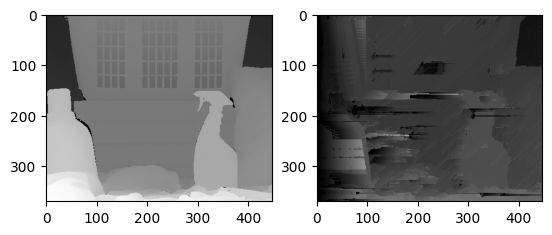

In [46]:
plt.subplot(1, 2, 1)
plt.imshow(svs[0].gl, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dm, cmap='gray')
print(Similarity.RANK(svs[0].gl, dm))

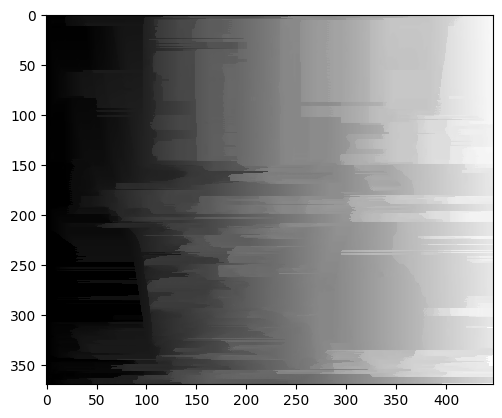

In [32]:
plt.imshow(svs[0].corresponding_points, cmap='gray')

In [47]:
similarities = [Similarity.SSD, Similarity.ZNCC, Similarity.CENSUS, Similarity.RANK]
window_sizes = [3, 5, 7, 9]

for similarity in similarities:
    for window_size in window_sizes:
        for sv in svs:
            dm = sv.constrained_disparity(window_size, similarity, 15)
            os.makedirs(f'saved/constrained/{sv.folder.split("/")[-1]}/', exist_ok=True)
            Image.fromarray(dm.astype(float)).convert('L').save(f'saved/constrained/{sv.folder.split("/")[-1]}/{similarity.__name__}_{window_size}.png')

100%|██████████| 370/370 [00:55<00:00,  6.65it/s]


In [5]:
similarities = [Similarity.ZNCC, Similarity.CENSUS, Similarity.RANK]
window_sizes = [3, 5, 7, 9]

for similarity in similarities:
    for window_size in window_sizes:
        for sv in svs:
            dm = sv.unconstrained_disparity(window_size, similarity)
            os.makedirs(f'saved/unconstrained/{sv.folder.split("/")[-1]}/', exist_ok=True)
            Image.fromarray(dm.astype(float)).convert('L').save(f'saved/unconstrained/{sv.folder.split("/")[-1]}/{similarity.__name__}_{window_size}.png')

100%|██████████| 370/370 [00:59<00:00,  6.17it/s]


In [8]:
disparity = 'unconstrained'
folder = 'Reindeer'
method = 'SSD'
window_size = 3

pred = np.asarray(Image.open(f'saved/{disparity}/{folder}/{method}_{window_size}.png'))
ground = np.asarray(Image.open(f'data/{folder}/disp1.png'))

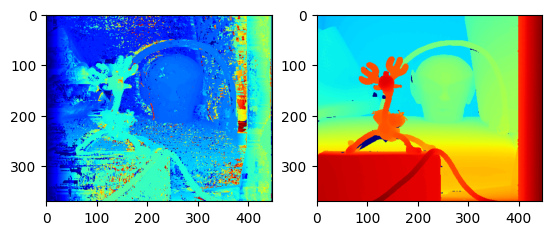

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(pred, cmap='jet')
plt.subplot(1, 2, 2)
plt.imshow(ground, cmap='jet')

In [16]:
similarities = [Similarity.SSD, Similarity.ZNCC, Similarity.CENSUS, Similarity.RANK]

results = {similarity.__name__: similarity(ground, pred) for similarity in similarities}

In [17]:
results

{'SSD': np.float64(-112.35399359090631),
 'ZNCC': np.float64(0.42799930160799876),
 'CENSUS': -0.16246447790071952,
 'RANK': np.float64(0.5641243644163302)}